## FaceRecognition #9
- Tool for recognizing people's front-facing pictures
- Performance tests discarding profile pictures

### Algorithm development

In [18]:
import argparse
import pickle
import cv2
from imutils import paths
import face_recognition
import argparse
import pickle
import cv2
import os
import dlib
import matplotlib.pyplot as plt
import numpy as np
import time
import random

print(dlib.DLIB_USE_CUDA)
#dlib.DLIB_USE_CUDA = True

True


In [19]:
import json
root_path = "./"
with open( root_path +'labelled_videos.json') as json_file:
    data_json = json.load(json_file)
    
def readTrueName(rec_name):
    if( data_json is None):
        return "Error"
    for real_name in data_json:
        if rec_name in data_json[real_name]:
            return real_name
    return "unknown"

#### ROC curve

In [20]:
import os
import numpy as np

def computeFAR(FAR_path, values):
    log_folder = FAR_path
    files = os.listdir(log_folder)


    confirmed_rate = np.zeros(len(values))
    i = 0

    for thr in values:
        total_files = 0
        recognized = 0
        notdetected = 0
        wrong = 0
        wrong_confirmed = 0
        wrong_confirmed2 = 0
        wrong_confirmed3 = 0
        wrong_confirmed4 = 0

        ####
        one_wrong_rec = 0
        persons = 0
        for f in files:
            if( f.startswith('log') == True):
                filev = open(log_folder + f, "r")
                vector = f.split('_')[1].split(".")[0]
                correct_person = readTrueName(vector + ".webm")
                lines = filev.readlines()
                persons += 1
                for line in lines: 
                    #we don't want to make statistics on the same person
                    name = line.split(' ')[0] + ".webm"
                    if(readTrueName(name) == correct_person):
                        continue

                    total_files += 1

                    rec_flag = line.split(' ')[2]
                    rec_percentage = float(line.split(' ')[3])
                    notdec_percentage = float(line.split(' ')[4])
                    notrec_percentage = float(line.split(' ')[5])

                    recognized = recognized + rec_percentage
                    notdetected = notdetected + notdec_percentage
                    wrong = wrong + notrec_percentage

                    if(notrec_percentage > thr):
                        wrong_confirmed = wrong_confirmed + 1

        if(total_files == 0):
            total_files = 1
        confirmed_rate[i] = wrong_confirmed / total_files
        wrong_confirmed = 0
        i = i +1

    ## equal for each iteration
    positive = recognized / total_files 
    undetected = notdetected / total_files
    negative = wrong / total_files

    wrong_rec_on_persons = one_wrong_rec / (persons-1)
    return confirmed_rate

In [21]:
import numpy as np
import os

def computeTAR(TAR_path, values):
    files = os.listdir(TAR_path)
    confirmed_rateT = np.zeros(len(values))
    i=0

    for thr in values:
        total_files = 0
        recognized = 0
        notdetected = 0
        wrong = 0
        confirmed = 0
        total_files = 0

        for f in files:
            if( f.startswith('log') == True):
                filev = open(TAR_path + f, "r")
                lines = filev.readlines()
                for line in lines:
                    total_files += 1

                    try:
                        rec_flag = line.split(' ')[2]
                        rec_percentage = float(line.split(' ')[3])
                        notdec_percentage = float(line.split(' ')[4])
                        notrec_percentage = float(line.split(' ')[5])

                        recognized = recognized + rec_percentage
                        notdetected = notdetected + notdec_percentage
                        wrong = wrong + notrec_percentage
                        if(rec_percentage > thr):
                            confirmed = confirmed + 1

                    except IndexError:
                        print(line)

        confirmed_rateT[i] = confirmed / total_files

        positive = recognized / total_files 
        undetected = notdetected / total_files
        negative = wrong / total_files

        i = i + 1
    return confirmed_rateT

In [22]:
from sklearn.metrics import roc_curve, auc

def plotROCcurve(TAR_path, FAR_path, description="20_20_0.50"):
    values = [0.1, 0.5, 0.10, 0.20, 0.30, 0.40, 0.45, 0.55, 0.60, 0.65, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99, 0.9999]
    f = description.split("_")
    print("Embeddings train:",f[0])
    print("Embeddings test:",f[1])
    print("Tolerance:", f[2])
    fpr = computeFAR(FAR_path, values)
    tpr = computeTAR(TAR_path, values)
    exampleX = [0.0, 0.0000001, 0.2, 0.8, 1.0]
    exampleY = [0.0, 1.0, 1.0, 1.0, 1.0]
    limitx = np.max(fpr)

    plt.figure()
    lw = 2
    plt.plot(exampleX, exampleY, color='green', linestyle='-', label='Ideal ROC')
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random case')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

    plt.figure()
    lw = 2
    plt.plot(exampleX, exampleY, color='green', linestyle='-', label='Ideal ROC')
    plt.scatter(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
    plt.scatter(fpr[5], tpr[5], color='red',lw=lw, label='thr: 0.4')
    plt.scatter(fpr[6], tpr[6], color='blue',lw=lw, label='thr: 0.45')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random case')
    plt.xlim([-0.001, limitx+0.02])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Zooming in the ROC curve')
    plt.legend(loc="lower right")
    plt.show()

    print("Threshold:", values[4], "TAR:", tpr[4], "FAR", fpr[4])
    print("Threshold:", values[5], "TAR:", tpr[5], "FAR", fpr[5])
    print("Threshold:", values[6], "TAR:", tpr[6], "FAR", fpr[6])
    print("Threshold:", values[7], "TAR:", tpr[7], "FAR", fpr[7])

#### Front-facing picture detection

Face


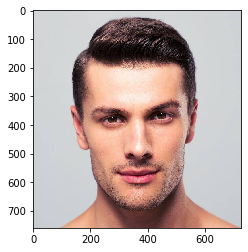

[{'chin': [(169, 372), (175, 424), (189, 477), (201, 531), (216, 583), (243, 629), (282, 666), (327, 694), (378, 700), (425, 689), (463, 657), (493, 615), (514, 565), (523, 511), (530, 458), (538, 405), (540, 352)], 'left_eyebrow': [(200, 359), (229, 338), (264, 337), (298, 343), (333, 354)], 'right_eyebrow': [(394, 350), (424, 334), (455, 321), (490, 314), (516, 333)], 'nose_bridge': [(365, 381), (368, 418), (370, 456), (371, 494)], 'nose_tip': [(332, 513), (351, 519), (371, 526), (388, 518), (404, 510)], 'left_eye': [(244, 387), (265, 376), (291, 375), (312, 389), (289, 395), (264, 396)], 'right_eye': [(411, 381), (433, 364), (458, 361), (478, 370), (462, 383), (437, 384)], 'top_lip': [(291, 569), (319, 564), (346, 558), (367, 564), (387, 557), (412, 559), (440, 559), (428, 566), (388, 574), (367, 577), (346, 575), (303, 573)], 'bottom_lip': [(440, 559), (416, 587), (392, 601), (370, 605), (348, 603), (320, 592), (291, 569), (303, 573), (347, 577), (369, 579), (389, 575), (428, 566)]

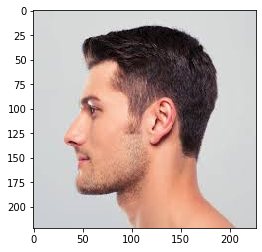

[]


In [23]:
import face_recognition
print("Face")
img = cv2.imread("./test-viso.jpg")
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)
plt.show()
image = face_recognition.load_image_file("./test-viso.jpg")
face_landmarks_list = face_recognition.face_landmarks(image)
print(face_landmarks_list)

print("")
print("Profile")

img = cv2.imread("./test-profilo.jpg")
rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb)
plt.show()
image = face_recognition.load_image_file("./test-profilo.jpg")
face_landmarks_list = face_recognition.face_landmarks(image)
print(face_landmarks_list)


#### Classification Test

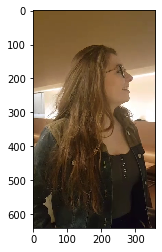

1 Profile picture


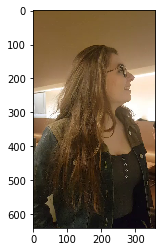

2 Profile picture


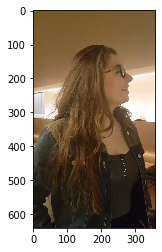

3 Profile picture


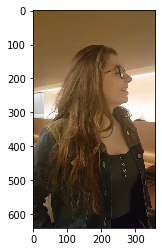

4 Profile picture


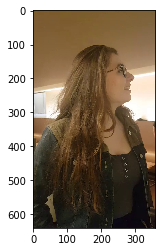

5 Profile picture


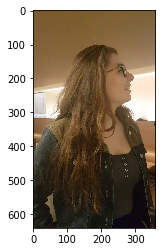

6 Profile picture


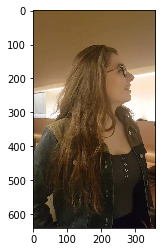

7 Profile picture


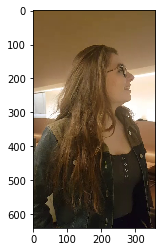

8 Profile picture


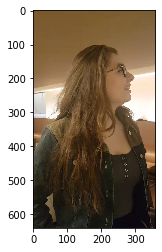

9 Front-facing picture


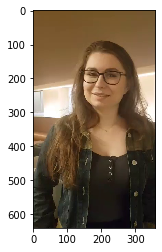

10 Front-facing picture


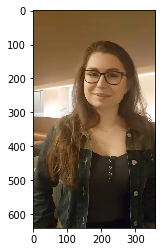

11 Front-facing picture


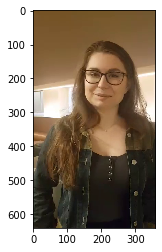

12 Front-facing picture


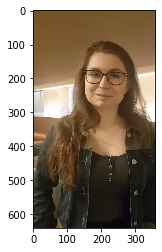

13 Front-facing picture


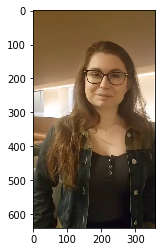

14 Front-facing picture


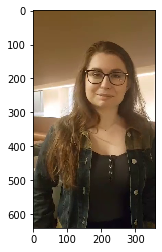

15 Front-facing picture


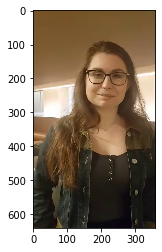

16 Front-facing picture


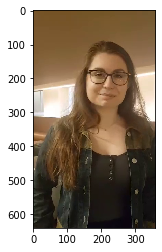

17 Front-facing picture


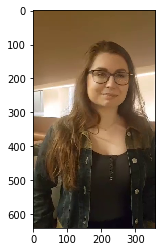

18 Front-facing picture


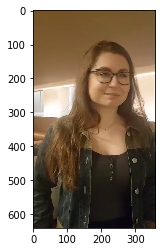

19 Profile picture


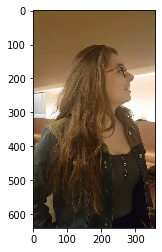

20 Front-facing picture


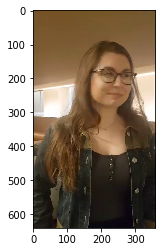

21 Front-facing picture


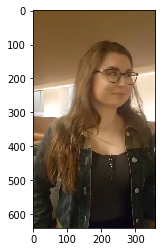

22 Profile picture


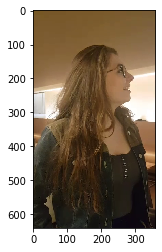

23 Profile picture


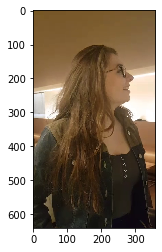

24 Profile picture


In [38]:
lotte_folder = "./z_Lotte/"
files = os.listdir(lotte_folder)
limit = 1000
count = 0

for f in files:
    count = count + 1
    if( count > limit):
        break
    face_img = face_recognition.load_image_file(lotte_folder +  f)
    face_landmarks_list = face_recognition.face_landmarks(face_img)
    plt.imshow(rgb)
    plt.show()
    img = cv2.imread(lotte_folder +  f)
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if(face_landmarks_list):
        print(count, "Front-facing picture")
    else:
        print(count, "Profile picture")


In [35]:
lotte_folder = "./z_Lotte_complete#delete/"
files = os.listdir(lotte_folder)
limit = 1000
count = 0

for f in files:
    count = count + 1
    if( count > limit):
        break
    face_img = face_recognition.load_image_file(lotte_folder +  f)
    face_landmarks_list = face_recognition.face_landmarks(face_img)
    if(face_landmarks_list):
        name = f.split(".")[0]
        newf = name + "_f." + f.split(".")[1]
        os.rename(lotte_folder + f, lotte_folder + newf)
    else:
        name = f.split(".")[0]
        newf = name + "_p." + f.split(".")[1]
        os.rename(lotte_folder + f, lotte_folder + newf) 

### Performance with front-facing pictures

In [ ]:
import json
root_path = "./"
with open( root_path +'labelled_videos.json') as json_file:
    data_json = json.load(json_file)
    
def readTrueName(rec_name):
    if( data_json is None):
        return "Error"
    for real_name in data_json:
        if rec_name in data_json[real_name]:
            return real_name
    return "unknown"

In [ ]:
import os
import numpy as np

def computeFAR(FAR_path, values):
    log_folder = FAR_path
    files = os.listdir(log_folder)


    confirmed_rate = np.zeros(len(values))
    i = 0

    for thr in values:
        total_files = 0
        recognized = 0
        notdetected = 0
        wrong = 0
        wrong_confirmed = 0
        wrong_confirmed2 = 0
        wrong_confirmed3 = 0
        wrong_confirmed4 = 0

        ####
        one_wrong_rec = 0
        persons = 0
        for f in files:
            if( f.startswith('log') == True):
                filev = open(log_folder + f, "r")
                vector = f.split('_')[1].split(".")[0]
                correct_person = readTrueName(vector + ".webm")
                lines = filev.readlines()
                persons += 1
                for line in lines: 
                    #we don't want to make statistics on the same person
                    name = line.split(' ')[0] + ".webm"
                    if(readTrueName(name) == correct_person):
                        continue

                    total_files += 1

                    rec_flag = line.split(' ')[2]
                    rec_percentage = float(line.split(' ')[3])
                    notdec_percentage = float(line.split(' ')[4])
                    notrec_percentage = float(line.split(' ')[5])

                    recognized = recognized + rec_percentage
                    notdetected = notdetected + notdec_percentage
                    wrong = wrong + notrec_percentage

                    if(notrec_percentage > thr):
                        wrong_confirmed = wrong_confirmed + 1

        if(total_files == 0):
            total_files = 1
        confirmed_rate[i] = wrong_confirmed / total_files
        wrong_confirmed = 0
        i = i +1

    ## equal for each iteration
    positive = recognized / total_files 
    undetected = notdetected / total_files
    negative = wrong / total_files

    wrong_rec_on_persons = one_wrong_rec / (persons-1)
    return confirmed_rate

In [ ]:
import numpy as np
import os

def computeTAR(TAR_path, values):
    files = os.listdir(TAR_path)
    confirmed_rateT = np.zeros(len(values))
    i=0

    for thr in values:
        total_files = 0
        recognized = 0
        notdetected = 0
        wrong = 0
        confirmed = 0
        total_files = 0

        for f in files:
            if( f.startswith('log') == True):
                filev = open(TAR_path + f, "r")
                lines = filev.readlines()
                for line in lines:
                    total_files += 1

                    try:
                        rec_flag = line.split(' ')[2]
                        rec_percentage = float(line.split(' ')[3])
                        notdec_percentage = float(line.split(' ')[4])
                        notrec_percentage = float(line.split(' ')[5])

                        recognized = recognized + rec_percentage
                        notdetected = notdetected + notdec_percentage
                        wrong = wrong + notrec_percentage
                        if(rec_percentage > thr):
                            confirmed = confirmed + 1

                    except IndexError:
                        print(line)

        confirmed_rateT[i] = confirmed / total_files

        positive = recognized / total_files 
        undetected = notdetected / total_files
        negative = wrong / total_files

        i = i + 1
    return confirmed_rateT

In [ ]:
from sklearn.metrics import roc_curve, auc

def plotROCcurve(TAR_path, FAR_path, description="20_20_0.50"):
    values = [0.1, 0.5, 0.10, 0.20, 0.30, 0.40, 0.45, 0.55, 0.60, 0.65, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99, 0.9999]
    f = description.split("_")
    print("Embeddings train:",f[0])
    print("Embeddings test:",f[1])
    print("Tolerance:", f[2])
    fpr = computeFAR(FAR_path, values)
    tpr = computeTAR(TAR_path, values)
    exampleX = [0.0, 0.0000001, 0.2, 0.8, 1.0]
    exampleY = [0.0, 1.0, 1.0, 1.0, 1.0]
    limitx = np.max(fpr)

    plt.figure()
    lw = 2
    plt.plot(exampleX, exampleY, color='green', linestyle='-', label='Ideal ROC')
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random case')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

    plt.figure()
    lw = 2
    plt.plot(exampleX, exampleY, color='green', linestyle='-', label='Ideal ROC')
    plt.scatter(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
    plt.scatter(fpr[5], tpr[5], color='red',lw=lw, label='thr: 0.4')
    plt.scatter(fpr[6], tpr[6], color='blue',lw=lw, label='thr: 0.45')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random case')
    plt.xlim([-0.001, limitx+0.02])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Zooming in the ROC curve')
    plt.legend(loc="lower right")
    plt.show()

    print("Threshold:", values[4], "TAR:", tpr[4], "FAR", fpr[4])
    print("Threshold:", values[5], "TAR:", tpr[5], "FAR", fpr[5])
    print("Threshold:", values[6], "TAR:", tpr[6], "FAR", fpr[6])
    print("Threshold:", values[7], "TAR:", tpr[7], "FAR", fpr[7])

#### Encoding creation

In [14]:
def readFrames(path):

    video = cv2.VideoCapture(path)
    count = 0
    frames = []
    while(1):
        ret, frame = video.read()
        if ret == True:
            frames.append(frame)
            count += 1
        else:
            break

    return frames

def createEncodingsandBoxesFromVector(dataset_vector, name , detection = 'cnn'):

    # grab the paths to the input images in our dataset
    print("[INFO] quantifying faces...")
    '''
    We're going to take only a limit number of images to create the encodings.
    We'll take a random sample over all the images of a person and in particular
    '''
    boxfile = open("./boxes_" + str(boxnum) + "/box_" + name[:-5] + ".pkl", "wb")
    
    if len(dataset_vector )<= 0:
        print("AN ERROR OCCURRED FOR ",name)
        return

    images = random.choices(dataset_vector, k = num, )

    # initialize the list of known encodings and known names
    knownEncodings = []
    knownNames = []
    
    ratios = []
    face_areas = []
    image_areas = []
    landmarks = []
        
    # loop over the image paths
    for image in images:
        # extract the person name from the image path
        #print("[INFO] processing image {}/{}".format(i + 1,len(imagePaths)))

        # load the input image and convert it from RGB (OpenCV ordering)
        # to dlib ordering (RGB)
        rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #estimate landmark to understand face position
        landmark = face_recognition.face_landmarks(rgb)
        # detect the (x, y)-coordinates of the bounding boxes
        # corresponding to each face in the input image
        boxes = face_recognition.face_locations(rgb,model=detection) 

        ######################### FACE RESOLUTION LOGIC
        for face_location in boxes:
            try:
                top, right, bottom, left = face_location
            except IndexError:
                top = right = bottom = left = 0

            area_face = (bottom-top) * (right-left)
            area_image = image.shape[0] * image.shape[1]
            ratio = area_face/area_image * 100
            #print('face:', area_face, 'image:', area_image, 'ratio:', ratio)

            ratios.append(ratio)
            face_areas.append(area_face)
            image_areas.append(area_image)
            landmarks.append(landmark)
        #########################
        
        # compute the facial embedding for the face
        encodings = face_recognition.face_encodings(rgb, boxes)

        # loop over the encodings
        for encoding in encodings:
            # add each encoding + name to our set of known names and
            # encodings
            knownEncodings.append(encoding)
            knownNames.append(name)
    #pdb.set_trace()
    
    boxdata = {"ratio": ratios, "face": face_areas, "image": image_areas, "landmark": landmarks}
    boxfile.write(pickle.dumps(boxdata))
    boxfile.close()

    
    # dump the facial encodings + names to disk
    print("[INFO] serializing encodings..." + name)
    data = {"encodings": knownEncodings, "names": knownNames}
    file_name = root_path + "encodings_" + str(num) + "/" + name[:-5] + '.pkl'
    
    print(len(knownEncodings))

    log_errors = False
    if( log_errors == True):
        if len(knownEncodings) > 25:
            f = open(root_path + "/encodings_face_videos/" + 'multiple_people.txt', 'a')
            f.write(name + '\n')
            f.close()
        if len(knownEncodings) <= 0:
            f = open(root_path + "/encodings_face_videos/" + 'not_recognisable.txt', 'a')
            f.write(name + '\n')
            f.close()
      

    f = open(file_name, "wb")
    f.write(pickle.dumps(data))
    f.close()

In [ ]:
base_path = "../#6/videos/"
root_path = "./"
videos = os.listdir(base_path)
global_start = time.time()
count = 0
num = 22
boxnum = num

count = 0
for video_name in videos:
    count += 1
    if(count < 0):
        continue
    start = time.time()
    frames = readFrames(base_path + video_name)
    createEncodingsandBoxesFromVector(frames, video_name)
    end = time.time()
    print(count/len(videos), 'Time_enc:', end-start)


global_end = time.time()
print('Time_enc:', global_end-global_start)

In [25]:
target_folder = "./encodings_22/"
files = os.listdir(target_folder)
count = 0
for file in files:
    filewebm = file[:-4] + ".webm"
    #print(file)
    print(readTrueName(filewebm))
    if( readTrueName(filewebm) == "unknown"):
        os.remove(target_folder + file)
        count += 1
print(count)

gregoire
documents
juliette
damien
damien
damien
antoine
gregoire
gregoire
unknown
damien
gregoire
damien
solene
sam
christophe
gregoire
christophe
unknown
sacha
sacha
antoine
gregoire
damien
gregoire
solene
damien
unknown
damien
damien
documents
unknown
unknown
gregoire
gregoire
damien
damien
documents
malory
damien
damien
gregoire
christophe
christophe
solene
christophe
solene
christophe
sam
solene
documents
damien
documents
sam
unknown
christophe
damien
christophe
gregoire
sacha
gregoire
solene
gregoire
unknown
malory
gregoire
gregoire
gregoire
antoine
malory
gregoire
malory
documents
malory
gregoire
malory
damien
malory
gregoire
gregoire
gregoire
gregoire
gregoire
antoine
solene
solene
gregoire
documents
sam
unknown
damien
solene
damien
malory
gregoire
damien
malory
sam
malory
documents
damien
documents
documents
documents
gregoire
solene
gregoire
gregoire
unknown
malory
gregoire
documents
gregoire
damien
sam
solene
documents
gregoire
christophe
gregoire
unknown
sacha
documents
dam

#### Functions

In [44]:
total_ignored = 0
total_frames_ = 0
total_profile_ = 0

In [45]:
def faceRecognitionENC(encodings_1, encodings_2, infos, detection='cnn', show=False, tolerance = 0.6, min_area = 1):
    '''
    It only works with already made encodings
    encodings_1: single encoding of the person we want to recognize
    encodings_2: encodings of the person of which we know the name
    '''
    global total_profile_

    start = time.time()

    data = encodings_2

    # initialize the list of names for each face detected
    names = []
    
    ######################### Discarding LOGIC
    discarded = "discarded"
    ratio = infos[0]
    landmark = infos[1]
    
    if (landmark == 0):
        total_profile_ = total_profile_ + 1
        print("W")
        return discarded
    if (ratio < min_area):
        #discard the picture
        return discarded
    #########################
    
    # attempt to match each encoding to our known encodings

    matches = face_recognition.compare_faces(data["encodings"],encodings_1, tolerance= tolerance)
    name = "unknown"

    # check to see if we have found a match
    if True in matches:
      # Or instead, use the known face with the smallest distance to the new face
        face_distances = face_recognition.face_distance(data["encodings"], encodings_1)
        best_match_index = np.argmin(face_distances)
        if matches[best_match_index]:
            name = data["names"][best_match_index]

    # update the list of names
    try:
        name = name.split('/')[2]
    except:
        name = name
    names.append(name)

    return names
    
def encodingsRead(path):
    data = pickle.loads(open(path, "rb").read())
    return data

def boxesRead(path):
    try:
        data = pickle.loads(open(path, "rb").read())
    except FileNotFoundError:
        boxdata= np.ones(100)
        data = {"ratio": boxdata, "face": boxdata, "image": boxdata}
        print("---- Default box construction")
    return data

In [60]:
def faceRecOnEnc(encoding_path, encodings, correct_person, detection='cnn', min_threshold = 0.85, 
                    max_threshold=0.10, show=False, tolerance = 0.6, stopping_perc = 0.50, min_area = 1):   
    ## encoding_path -> test
    ## encodings -> train
    
    print(correct_person)
    box_path = "./boxes_" + str(boxnum) + "/box_" + correct_person + ".pkl"
    correct_person = readTrueName(correct_person + ".webm")
    encodings_to_compare = encodingsRead(encoding_path)
    boxes_to_compare = boxesRead(box_path)
    encodings_to_compare = encodings_to_compare["encodings"]#ecoding of a different person
    ratio_to_compare = boxes_to_compare['ratio']
    try:
        landmark_to_compare = boxes_to_compare['landmark']
    except KeyError:
        landmark_to_compare = np.ones(1000)
    total_frames = len(encodings_to_compare)
    min_frames = total_frames * stopping_perc / 100
    
    analysed_frames = 0
    neutrum_frames = 0
    correct_frames = 0
    negative_frames = 0
    ignored_frames = 0
    global total_ignored
    global total_frames_
    
    start = time.time()
    
    # grab the paths to the input images in our dataset
    print("[INFO] Recognizing faces...")
    total_frames = len(encodings_to_compare)
    print("[INFO] elements:", total_frames)

    #we had some cases where no faces where recognised
    if len(encodings_to_compare) == 0:
        return False, 0, 0, 0

    #pdb.set_trace()
    # loop over the encodings
    infos = np.zeros(2)
    frame_count = 0
    min_area_max = np.max(ratio_to_compare) * ((-1) * min_area) / 100
    for enc in encodings_to_compare:
        # extract the person name from the image path
        #print("[INFO] processing image {}/{}".format(i + 1,len(imagePaths)))
        
        ratio = ratio_to_compare[frame_count]
        landmark = landmark_to_compare[frame_count]
        if( min_area < 0): 
            min_area = min_area_max
        #image = imageRead(imagePath, show=False)
        infos[0] = ratio
        if (not landmark):
            infos[1] = 0 # 0 profile
        else:
            infos[1] = 1 #front-facing
        person_rec = faceRecognitionENC(enc, encodings, infos, detection='cnn', tolerance = tolerance, show=show,
                                       min_area = min_area)
        analysed_frames += 1
        frame_count += 1 
        total_frames_ = total_frames_ + 1 #global
        
        if( person_rec == "discarded"):
            # we are ignoring the frame
            analysed_frames -= 1
            ignored_frames += 1 
            print("Discarded frame", frame_count, "ratio:", ratio)
        elif(len(person_rec) >= 1):
            ## modified
            person = readTrueName(person_rec[0])
            if(person == correct_person):
                correct_frames += 1
            else:
                if(person == 'unknown'):
                    neutrum_frames += 1
                else:
                    negative_frames += 1
        else:
            neutrum_frames += 1
        
        
        if( analysed_frames > min_frames and correct_frames/analysed_frames > min_threshold):
            print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/analysed_frames)
            print('Not detected:', neutrum_frames/analysed_frames, ". Wrong recognition:", negative_frames/analysed_frames)
            correct_rate = correct_frames/analysed_frames
            neutrum_rate = neutrum_frames/analysed_frames
            negative_rate = negative_frames/analysed_frames
            total_ignored = total_ignored + ignored_frames
            end = time.time()
            print('Time:', end-start)
            return True, correct_rate, neutrum_rate, negative_rate
        
        if( analysed_frames > min_frames and negative_frames/analysed_frames > min_threshold):
            print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/analysed_frames)
            print('Not detected:', neutrum_frames/analysed_frames, ". Wrong recognition:", negative_frames/analysed_frames)
            correct_rate = correct_frames/analysed_frames
            neutrum_rate = neutrum_frames/analysed_frames
            negative_rate = negative_frames/analysed_frames
            total_ignored = total_ignored + ignored_frames
            end = time.time()
            print('Time:', end-start)
            return True, correct_rate, neutrum_rate, negative_rate
        
        if( analysed_frames > min_frames and (negative_frames+correct_frames)/analysed_frames < max_threshold):
            print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/analysed_frames)
            print('Not detected:', neutrum_frames/analysed_frames, ". Wrong recognition:", negative_frames/analysed_frames)
            correct_rate = correct_frames/analysed_frames
            neutrum_rate = neutrum_frames/analysed_frames
            negative_rate = negative_frames/analysed_frames
            total_ignored = total_ignored + ignored_frames
            end = time.time()
            print('Time:', end-start)
            return False, correct_rate, neutrum_rate, negative_rate
        
        #########################

    #for ends
    if(total_frames == 0 or analysed_frames == 0):
        total_frames = 1
        analysed_frames = 1
    correct_rate = correct_frames/analysed_frames
    neutrum_rate = neutrum_frames/analysed_frames
    negative_rate = negative_frames/analysed_frames
    total_ignored = total_ignored + ignored_frames   
    end = time.time()
    print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/total_frames)
    print('Not detected:', neutrum_frames/total_frames, ". Wrong recognition:", negative_frames/total_frames)
    print('Time:', end-start)
    if(correct_rate > min_threshold - 0.05):
        return True, correct_rate, neutrum_rate, negative_rate
    else:
        return False, correct_rate, neutrum_rate, negative_rate

In [61]:

def performCrossedTestENC(min_v=0, max_v=1000, false_threshold=0.10, true_threshold=0.85, log=False,
                          tolerance = 0.6, min_area = 1):
    csv = False
    stop_percentage = 40
    print("-------------------------")
    print("TEST STARTED")
    print("-------------------------")
    start = time.time()
    count = 0
    enc_list = os.listdir(encodings_folder)
    test_dir = os.listdir(test_path)
    
    csv_folder_base = root_path
    f = open(csv_folder_base +'CrossTest' + str(tolerance) +'.csv', 'w')

    if (csv == True and f != None):
        writer = csv.writer(f)

    p_count = 0
    for encoding in enc_list:
        start_2 = time.time()    
        p_count += 1
        if( p_count > testing_limit):
            break
        count = count + 1
        if(count < min_v):
            continue
        if(count > max_v):
            break

        enc_name = encoding[0:len(encoding)-4]#removing '.pkl' from name
        encoding_path = encodings_folder + encoding
        print('[ENC] Using encoding:', enc_name)
        start_2 = time.time()
        curr_encoding = encodingsRead(encoding_path)

        if( log == True ):
            logs_folder = "./logs_" + str(tolerance) + key + "/F/"
            logfile = open(logs_folder + "log_" + enc_name + ".txt", "w")
            
        row = []
        row.append(enc_name)
        for person in test_dir:    
            if ( readTrueName(enc_name +".webm") == readTrueName(person[0:len(person)-4] +".webm") ):#removing '.pkl' from name 
                continue
            if ( readTrueName(enc_name +".webm") == 'documents'):
                continue

            test_enc = test_path + person            
            person_name = person[0:len(person)-4]
            print('Testing on test encoding:', person)

            # test the encodings of testset               
            v, a, b, c = faceRecOnEnc(test_enc, curr_encoding, person_name, min_threshold=true_threshold,
                                         max_threshold = false_threshold, tolerance = tolerance, 
                                         stopping_perc = stop_percentage, min_area = min_area, show=False)
            if (v == True):
                row.append(person)
            if(log== True):
                line = person + " " + "0" + " " + str(v) + " " + str(a) + " " + str(b) + " " + str(c) + "\n"
                logfile.write(line)
                
        #FINE DELLA PERSONA
        if(log == True):
            logfile.close()        
        if( csv == True):
            #writing on the csv the line of all the videos in which the èerson is recognised
            writer.writerow(row)
            
        
        end_2 = time.time()    
        print("-------------------------")
        print('The comparison last:', end_2-start_2)
        print("-------------------------")
    
    end = time.time()
    print("-------------------------")
    print("TEST ENDED")
    print("-------------------------")
    print('This test last:', end-start)
    f.close()
    return

In [62]:
testing_limit = 100000
def performTestENC(min_v=0, max_v=1000, false_threshold=0.10, true_threshold=0.85, log=False, tolerance = 0.6,
                  min_area = 1):
    csv = False
    stop_percentage = 40
    logplus = True
    print("-------------------------")
    print("TEST STARTED")
    print("-------------------------")
    start = time.time()
    count = 0
    enc_list = os.listdir(encodings_folder)
    test_dir = os.listdir(test_path)
    
    csv_folder_base = root_path
    f = open(csv_folder_base +'CrossTest' + str(tolerance) +'.csv', 'w')

    if (csv == True and f != None):
        writer = csv.writer(f)
    if( log == True ):
        logs_folder = "./logs_" + str(tolerance) + key + "/T/"
        #logs_folder = "./logs/T/"
        logfile = open(logs_folder + "log_" + str(min_v) + "_" + str(max_v) + ".txt", "w")
    if (logplus == True):
        logs_folder = "./logs_" + str(tolerance) + key + "/T+/"
        #logs_folder = "./logs/T/"
        fileplus = open(logs_folder + "log_" + str(min_v) + "_" + str(max_v) + ".txt", "w")

    p_count = 0
    for encoding in enc_list:
        start_2 = time.time()    
        p_count += 1
        if( p_count > testing_limit):
            break
        count = count + 1
        if(count < min_v):
            continue
        if(count > max_v):
            break

        enc_name = encoding[0:len(encoding)-4]#removing '.pkl' from name
        encoding_path = encodings_folder + encoding
        print('[ENC] Using encoding:', enc_name)
        start_2 = time.time()
        curr_encoding = encodingsRead(encoding_path)
            
        row = []
        row.append(enc_name)
        t_count = 0
        for person in test_dir:    
            if ( readTrueName(enc_name +".webm") != readTrueName(person[0:len(person)-4] +".webm") ):#removing '.pkl' from name 
                continue
            if ( readTrueName(enc_name +".webm") == 'documents'):
                continue

            test_enc = test_path + person            
            person_name = person[0:len(person)-4]
            print('Testing on test encoding:', person)

            # test the encodings of testset               
            v, a, b, c = faceRecOnEnc(test_enc, curr_encoding, person_name, min_threshold=true_threshold,
                                         max_threshold = false_threshold, tolerance = tolerance, 
                                         stopping_perc = stop_percentage,  min_area = min_area, show=False)
            
            if (v == True):
                row.append(person)
            if(log== True):
                line = person + " " + str(t_count) + " " + str(v) + " " + str(a) + " " + str(b) + " " + str(c) + "\n"
                logfile.write(line)
            if(logplus == True):
                line = person + " " + enc_name + " " + str(v) + " " + str(a) + " " + str(b) + " " + str(c) + "\n"
                fileplus.write(line)
            t_count += 1
                
        if( csv == True):
            #writing on the csv the line of all the videos in which the èerson is recognised
            writer.writerow(row)
            
        
        end_2 = time.time()    
        print("-------------------------")
        print('The comparison last:', end_2-start_2)
        print("-------------------------")
    #FINE DELLA PERSONA
    if(log == True):
        logfile.close() 
    if(logplus == True):
        fileplus.close()
    
    end = time.time()
    print("-------------------------")
    print("TEST ENDED")
    print("-------------------------")
    print('This test last:', end-start)
    f.close()
    return

#### Test 1A
- Front Facing
- Face crop resolution
- Encodings: 35

In [ ]:
# an area lower that 50% of the maximum is refused
boxnum = 35
root_path = "./"
encodings_folder = "./encodings_35/"
test_path = "./encodings_35/"
key = "_areaMAX50"
total_frames_ = 0
total_ignored = 0
total_profile_ = 0
performTestENC(false_threshold=0.10, true_threshold=0.45, log=True, tolerance = 0.45, min_area = -50)
#performCrossedTestENC(false_threshold=0.10, true_threshold=0.45, log=True, tolerance = 0.45, min_area = -50)

Percentage of overall images that were discarded: 0.3912555446318674


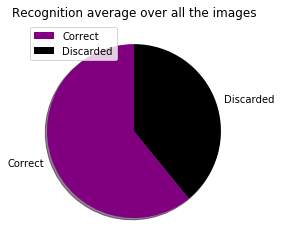

In [93]:
discarded = total_ignored/total_frames_
labels = ['Correct', 'Discarded']
colors = ['Purple', 'Black']
sizes1 = [(1-discarded), discarded]
print('Percentage of overall images that were discarded:', discarded)

plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
plt.title('Recognition average over all the images')
plt.legend()
plt.show()

Percentage of overall images that were discarded because of profile: 0.12123229523890622
Percentage of overall images that were discarded because of face crop: 0.2700232493929612


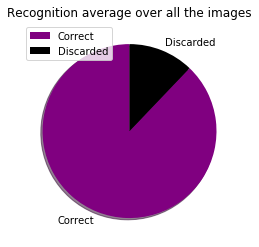

In [94]:
profile_d = total_profile_/total_frames_
labels = ['Correct', 'Discarded']
colors = ['Purple', 'Black']
sizes1 = [(1-profile_d), profile_d]
print('Percentage of overall images that were discarded because of profile:', profile_d)
print('Percentage of overall images that were discarded because of face crop:', discarded-profile_d)


plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
plt.title('Recognition average over all the images')
plt.legend()
plt.show()

Embeddings train: 35
Embeddings test: 35
Tolerance: 0.45


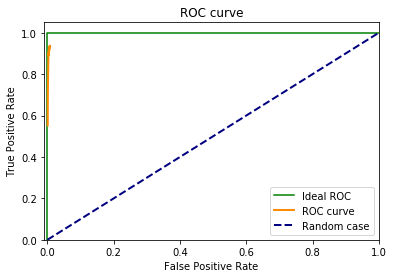

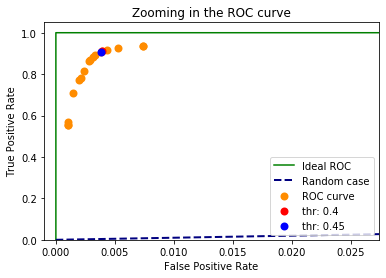

Threshold: 0.3 TAR: 0.9176376926974017 FAR 0.00431014771116294
Threshold: 0.4 TAR: 0.9106173554317145 FAR 0.00392143412447981
Threshold: 0.45 TAR: 0.9085908663240935 FAR 0.003841404856633283
Threshold: 0.55 TAR: 0.883187377867844 FAR 0.0031440069511135503


In [95]:
log_basic_path = "./logs_0.45_areaMAX50/"
T_path = log_basic_path + "T/"
F_path = log_basic_path + "F/"
desc = "35_35_0.45"
plotROCcurve(T_path, F_path, desc)

#### Test 1B
- NO Front Facing
- Face crop resolution
- Encodings: 35

In [ ]:
# an area lower that 50% of the maximum is refused
root_path = "./"
boxnum = 35
encodings_folder = "./encodings_35/"
test_path = "./encodings_35/"
key = "_areaMAX50_noP"
total_frames_ = 0
total_ignored = 0
total_profile_ = 0
performTestENC(false_threshold=0.10, true_threshold=0.45, log=True, tolerance = 0.45, min_area = -50)
#performCrossedTestENC(false_threshold=0.10, true_threshold=0.45, log=True, tolerance = 0.45, min_area = -50)

Percentage of overall images that were discarded: 0.31273687135315364


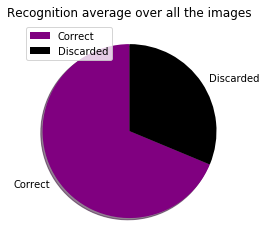

In [100]:
discarded = total_ignored/total_frames_
labels = ['Correct', 'Discarded']
colors = ['Purple', 'Black']
sizes1 = [(1-discarded), discarded]
print('Percentage of overall images that were discarded:', discarded)

plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
plt.title('Recognition average over all the images')
plt.legend()
plt.show()

Percentage of overall images that were discarded because of profile: 0.0
Percentage of overall images that were discarded because of face crop: 0.31273687135315364


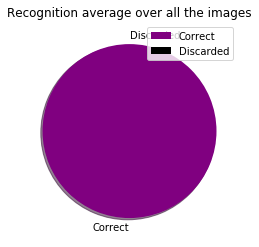

In [101]:
profile_d = total_profile_/total_frames_
labels = ['Correct', 'Discarded']
colors = ['Purple', 'Black']
sizes1 = [(1-profile_d), profile_d]
print('Percentage of overall images that were discarded because of profile:', profile_d)
print('Percentage of overall images that were discarded because of face crop:', discarded-profile_d)


plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
plt.title('Recognition average over all the images')
plt.legend()
plt.show()

Embeddings train: 35
Embeddings test: 35
Tolerance: 0.45


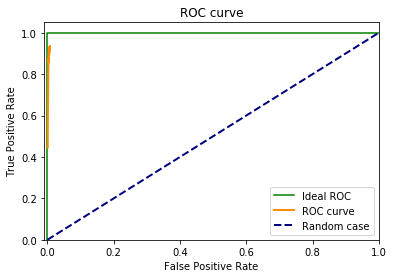

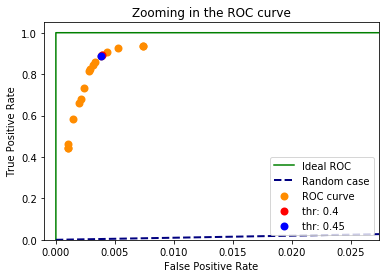

Threshold: 0.3 TAR: 0.9085184917131071 FAR 0.00431014771116294
Threshold: 0.4 TAR: 0.8919447057972063 FAR 0.00392143412447981
Threshold: 0.45 TAR: 0.8898458420785988 FAR 0.003841404856633283
Threshold: 0.55 TAR: 0.8456249547658682 FAR 0.0031440069511135503


In [102]:
log_basic_path = "./logs_0.45_areaMAX50_noP/"
T_path = log_basic_path + "T/"
F_path = log_basic_path + "F/"
desc = "35_35_0.45"
plotROCcurve(T_path, F_path, desc)

Here we use 35 encodings instead of 20, as did before. Using more encodings, the FAR increases.

The front-facing detection logic discards 7% of frames. The effect of this split is just increasing some points in TAR score. The FAR remains constant.

TAR increment is more visible using higher thresholds because fidelity in recognizing picture is higher. 

#### Test 2A
- Front Facing
- Ratio Face crop
- Encodings: 22

In [ ]:
# an area lower that 50% of the maximum is refused
root_path = "./"
boxnum = 22
encodings_folder = "./encodings_22/"
test_path = "./encodings_22/"
key = "_areaMAX50_22"
total_frames_ = 0
total_ignored = 0
total_profile_ = 0
performTestENC(false_threshold=0.10, true_threshold=0.45, log=True, tolerance = 0.45, min_area = -50)
performCrossedTestENC(false_threshold=0.10, true_threshold=0.45, log=True, tolerance = 0.45, min_area = -50)

Percentage of overall images that were discarded: 0.36286229285045524


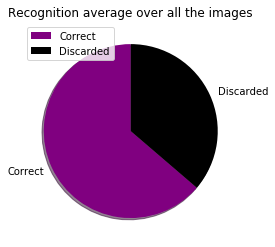

In [34]:
discarded = total_ignored/total_frames_
labels = ['Correct', 'Discarded']
colors = ['Purple', 'Black']
sizes1 = [(1-discarded), discarded]
print('Percentage of overall images that were discarded:', discarded)

plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
plt.title('Recognition average over all the images')
plt.legend()
plt.show()

Percentage of overall images that were discarded because of profile: 0.09337359432719786
Percentage of overall images that were discarded because of face crop: 0.2694886985232574


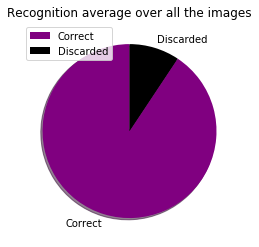

In [35]:
profile_d = total_profile_/total_frames_
labels = ['Correct', 'Discarded']
colors = ['Purple', 'Black']
sizes1 = [(1-profile_d), profile_d]
print('Percentage of overall images that were discarded because of profile:', profile_d)
print('Percentage of overall images that were discarded because of face crop:', discarded-profile_d)


plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
plt.title('Recognition average over all the images')
plt.legend()
plt.show()

Embeddings train: 22
Embeddings test: 22
Tolerance: 0.45


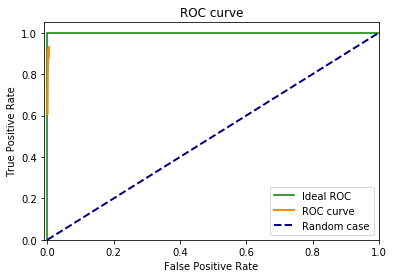

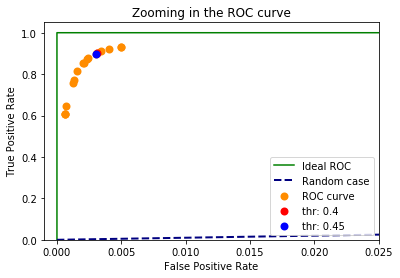

Threshold: 0.3 TAR: 0.9106584212440888 FAR 0.0034478355254756736
Threshold: 0.4 TAR: 0.9002546380502001 FAR 0.003128591495339037
Threshold: 0.45 TAR: 0.8972717351764278 FAR 0.003039203166900779
Threshold: 0.55 TAR: 0.8751546016733358 FAR 0.0023113267781892477


In [36]:
log_basic_path = "./logs_0.45_areaMAX50_22/"
T_path = log_basic_path + "T/"
F_path = log_basic_path + "F/"
desc = "22_22_0.45"
plotROCcurve(T_path, F_path, desc)

The refused matrics is counted on the number of picture that are 'not detected'. So, removing faces that are considered 'profile', we increase a bit the TAR but we decrease the FAR because less pictures are refused.


#### Test 2B
- NO Front Facing
- Face crop resolution
- Encodings: 22

In [ ]:
# an area lower that 50% of the maximum is refused
root_path = "./"
boxnum = 22
encodings_folder = "./encodings_22/"
test_path = "./encodings_22/"
key = "_areaMAX50_no22"
total_frames_ = 0
total_ignored = 0
total_profile_ = 0
performTestENC(false_threshold=0.10, true_threshold=0.45, log=True, tolerance = 0.45, min_area = -50)
performCrossedTestENC(false_threshold=0.10, true_threshold=0.45, log=True, tolerance = 0.45, min_area = -50)

Percentage of overall images that were discarded: 0.3075417531848632


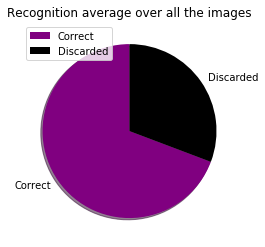

In [41]:
discarded = total_ignored/total_frames_
labels = ['Correct', 'Discarded']
colors = ['Purple', 'Black']
sizes1 = [(1-discarded), discarded]
print('Percentage of overall images that were discarded:', discarded)

plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
plt.title('Recognition average over all the images')
plt.legend()
plt.show()

Percentage of overall images that were discarded because of profile: 0.0
Percentage of overall images that were discarded because of face crop: 0.3075417531848632


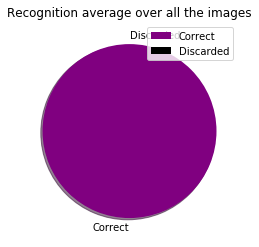

In [42]:
profile_d = total_profile_/total_frames_
labels = ['Correct', 'Discarded']
colors = ['Purple', 'Black']
sizes1 = [(1-profile_d), profile_d]
print('Percentage of overall images that were discarded because of profile:', profile_d)
print('Percentage of overall images that were discarded because of face crop:', discarded-profile_d)


plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
plt.title('Recognition average over all the images')
plt.legend()
plt.show()

Embeddings train: 22
Embeddings test: 22
Tolerance: 0.45


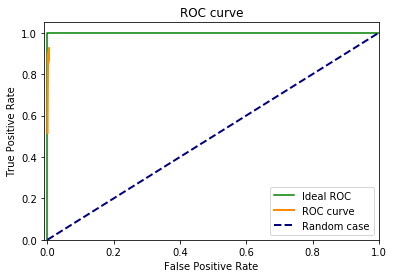

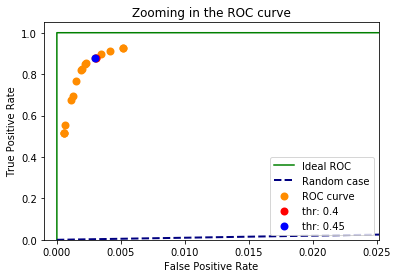

Threshold: 0.3 TAR: 0.8956711531465987 FAR 0.0034733750478866043
Threshold: 0.4 TAR: 0.8802473626773372 FAR 0.0030647426893117098
Threshold: 0.45 TAR: 0.8772644598035649 FAR 0.0030008938832843824
Threshold: 0.55 TAR: 0.850491087668243 FAR 0.0022219384497509896


In [43]:
log_basic_path = "./logs_0.45_areaMAX50_no22/"
T_path = log_basic_path + "T/"
F_path = log_basic_path + "F/"
desc = "22_22_0.45"
plotROCcurve(T_path, F_path, desc)

In [ ]:
# an area lower that 50% of the maximum is refused
root_path = "./"
boxnum = 20
encodings_folder = "./encodings_20/"
test_path = "./encodings_20/"
key = "_areaMAX50_20"
total_frames_ = 0
total_ignored = 0
total_profile_ = 0
performTestENC(false_threshold=0.10, true_threshold=0.45, log=True, tolerance = 0.45, min_area = -50)
performCrossedTestENC(false_threshold=0.10, true_threshold=0.45, log=True, tolerance = 0.45, min_area = -50)

In [ ]:
discarded = total_ignored/total_frames_
labels = ['Correct', 'Discarded']
colors = ['Purple', 'Black']
sizes1 = [(1-discarded), discarded]
print('Percentage of overall images that were discarded:', discarded)

plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
plt.title('Recognition average over all the images')
plt.legend()
plt.show()

In [ ]:
profile_d = total_profile_/total_frames_
labels = ['Correct', 'Discarded']
colors = ['Purple', 'Black']
sizes1 = [(1-profile_d), profile_d]
print('Percentage of overall images that were discarded because of profile:', profile_d)
print('Percentage of overall images that were discarded because of face crop:', discarded-profile_d)


plt.pie(sizes1, labels=labels, shadow=True, startangle=90, colors=colors)
plt.title('Recognition average over all the images')
plt.legend()
plt.show()

In [ ]:
log_basic_path = "./logs_0.45_areaMAX50_20/"
T_path = log_basic_path + "T/"
F_path = log_basic_path + "F/"
desc = "20_20_0.45"
plotROCcurve(T_path, F_path, desc)